In [1]:
import collections
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
with open("orda_annotations_0420.json", 'r') as f:
    orda_data = json.load(f)

DATA_DIR = "/Users/nnayak/git_repos/iclr-discourse-dataset/data/review_rebuttal_pair_dataset/"

# Heatmaps
* Argument-level disagreement
* Detailed disagreement -- Evaluative
* Detailed disagreement -- Request
* Detailed disagreement -- Evaluative v/s Request

* Arg1 v/s Arg2 (and how often)
* Aspect v/s Polarity
* Evaluative1 v/s Evaluative2

# Bar plots

* Arg type
  * v/s score
* Request type
  * v/s score
* Structuring type
  * Check v/s score
* Aspect
  * Aspect v/s score
* Aspect + Polarity
  * v/s score

In [2]:
# Data extraction
# Get all labels, including score 
# Code to count probabilities/conditional probabilities, and then make bar plots
rating_map = {}
acceptable_pairs = []
sentences = {}
rebuttal_sentences = {}
overall_stats_map = collections.defaultdict(list)
for dataset_name in "traindev_train traindev_dev traindev_test truetest".split():
    rating_counter = collections.Counter()
    with open(DATA_DIR + dataset_name + ".json", 'r') as f:
        text_obj = json.load(f)
    for pair in text_obj['review_rebuttal_pairs']:
        
        
        review_id = pair["review_sid"]
        overall_stats_map[review_id].append({
            "review_length":len(pair["review_text"]["sentences"]),
            "rebuttal_length":len(pair["rebuttal_text"]["sentences"]),
            "rating":pair["labels"]["rating"],
            
        })
        if dataset_name == "truetest":
            pass
        else:
            acceptable_pairs.append(pair["review_sid"])
        assert review_id not in rating_map
        rating_map[review_id] = pair["labels"]["rating"]
        rating_map[review_id] = pair["labels"]["rating"]
        for i, sent in enumerate(pair["review_text"]["sentences"]):
            sentences[(review_id, i)] = pair["review_text"]["text"][sent["start_index"]:sent["end_index"]]
        for i, sent in enumerate(pair["rebuttal_text"]["sentences"]):
            rebuttal_sentences[(review_id, i)] = pair["rebuttal_text"]["text"][sent["start_index"]:sent["end_index"]]

In [3]:
double_review_labels = {}

review_sentence_annotations = orda_data["reviewsentenceannotation"]
label_map = collections.defaultdict(list)
for sent in review_sentence_annotations:
    review_id, sentence_index = sent["fields"]["review_id"], sent["fields"]["review_sentence_index"]
    if review_id not in acceptable_pairs:
        continue
    elif rating_map[review_id] == 9:
        continue
    try:
        labels = json.loads(json.loads(sent["fields"]["labels"]))
    except TypeError:
        labels = json.loads(sent["fields"]["labels"])
    
    if not labels:
        continue
    elif labels["1"]:
        double_review_labels[(review_id, sentence_index)] = labels["1"]
    else:

        for index, label in labels.items():
            if not label:
                continue
            else:
                new_label_map = {}
                for key, val in label.items():
                    if '-' in val:
                        val = val[2:]
                    new_label_map[key] = val
                new_label_map["rating"] = rating_map[review_id]
                new_label_map["initials"] = sent["fields"]["initials"]
                label_map[(review_id, sentence_index)].append(new_label_map)

In [4]:
def normalize_percent(l):
    return [x*100/sum(l) for x in l]

def survey(results, category_names, normalize, label_map, title):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    
    if normalize:
        new_results = {}
        for k,v in results.items():
            new_results[k] = normalize_percent(v)
        results = new_results
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('YlGnBu')(
        np.linspace(0.15, data.shape[1] + 1))

    fig, ax = plt.subplots(figsize=(15, len(results)))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    
    if title:
        plt.title(title, loc="center", fontdict={'fontsize': 20})

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.75,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.25 else 'black'
        if normalize:
            fmt = "%.2f"
        else:
            fmt = "%g"
        ax.bar_label(rects, label_type='center', color=text_color, fmt=fmt)
#     ax.legend(ncol=len(category_names),
#               loc='upper right',
#               fontsize='small',
#               prop={'size': 12}, bbox_to_anchor=(0,-1,1,0))

#     plt.legend(loc=2,)
    return fig, ax


def survey_wrapper(row_key, cat_key, normalize, name, title, label_map):
    result_map = collections.defaultdict(collections.Counter)
    categories = set()
    for label_list in label_map.values():
        for labels in label_list:
            if row_key is None:
                if cat_key not in labels:
                    continue
                result_map[name][labels[cat_key]] += 1
            elif row_key not in labels or cat_key not in labels:
                continue
            else:
                result_map[labels[row_key]][labels[cat_key]] += 1
            categories.add(labels[cat_key])
    if cat_key == 'arg':
        categories_list = "Evaluative Request Fact Structuring Social Other".split()
    else:
        categories_list = list(sorted(categories))
    results = {k:[v[cat] for cat in categories_list] for k, v in result_map.items()}
    survey(results, categories_list, normalize, label_map, title=title)

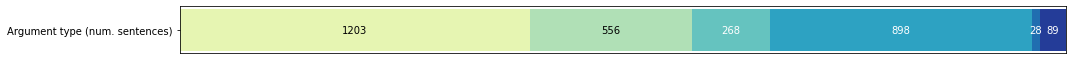

In [5]:
survey_wrapper(None, "arg", False, "Argument type (num. sentences)", "", label_map)
plt.tight_layout()
plt.savefig("arg_overall.png")

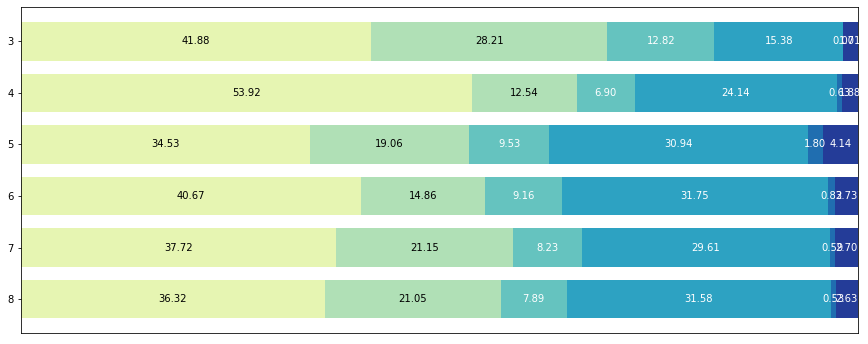

In [6]:
survey_wrapper("rating", "arg", True, "", "", label_map)
plt.savefig("arg_byrating.png")


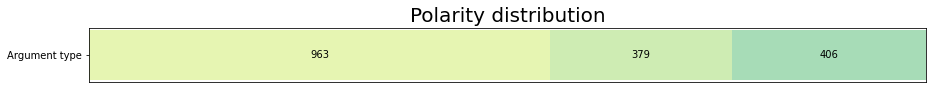

In [7]:
survey_wrapper(None, "pol", None, "Argument type", "Polarity distribution", label_map)

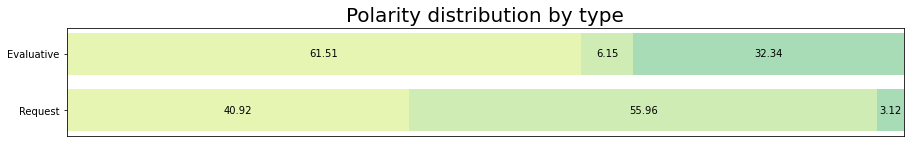

In [8]:
survey_wrapper("arg", "pol", True, "", "Polarity distribution by type", label_map)

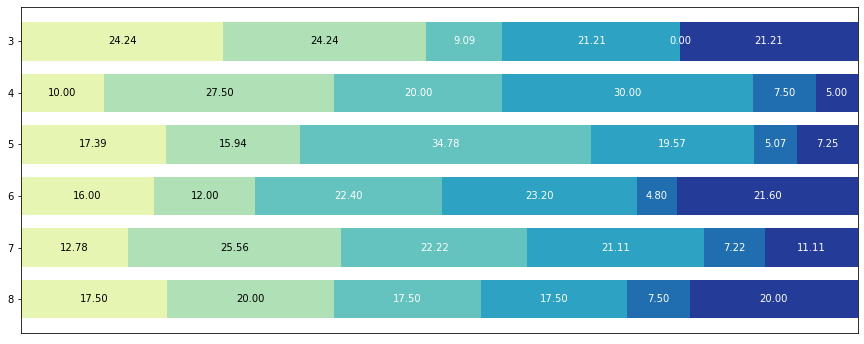

In [9]:
survey_wrapper("rating", "req", True, "", "", label_map)
plt.savefig('req_by_rating.png')

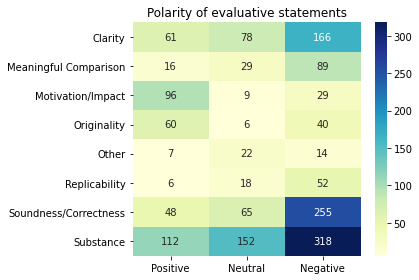

In [10]:
def make_confusion_matrix(cf,
                          group_names=None,
                          row_vals='auto',
                          col_vals='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=False,
                          sum_stats=True,
                          figsize=None,
                          cmap='YlGnBu',
                          title=None,
                          mask=False):


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    if mask:
        assert len(col_vals) == len(row_vals)
        mask = np.triu(np.ones([len(col_vals), len(col_vals)]), 1)
    else:
        mask=None
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=col_vals,yticklabels=row_vals,mask=mask)
    plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        

def heatmap_wrapper(row_key, col_key, label_map, title):
    result_map = collections.defaultdict(collections.Counter)
    row_vals = set()
    col_vals = set()
    for label_list in label_map.values():
        for labels in label_list:
            if row_key not in labels or col_key not in labels:
                continue
            else:
                row_val = labels[row_key]
                col_val = labels[col_key]
                result_map[row_val][col_val] += 1
                row_vals.add(row_val)
                col_vals.add(col_val)
    confusions = np.zeros([len(row_vals), len(col_vals)])
    row_vals = list(sorted(row_vals))
    if col_key == "pol":
        col_vals = "Positive Neutral Negative".split()
    else:
        col_vals = list(sorted(col_vals))
    for i, val1 in enumerate(row_vals):
        for j, val2 in enumerate(col_vals):
            confusions[i][j] += result_map[val1][val2]
    make_confusion_matrix(confusions, row_vals=row_vals, col_vals=col_vals, percent=False, title=title)

heatmap_wrapper("asp", "pol", label_map, title="Polarity of evaluative statements")
plt.tight_layout()
plt.savefig("eval_pol.png")

In [11]:
def confusion_wrapper(category, label_map, title):
    result_map = collections.defaultdict(collections.Counter)
    vals = set()
    for label_list in label_map.values():
        if len(label_list) == 2:
            label1, label2 = sorted(label_list,key=lambda x:x["initials"])
            val1 = label1.get(category, None)
            val2 = label2.get(category, None)
            if val1 is not None and val2 is not None:
                val1, val2 = reversed(sorted([val1, val2]))
                result_map[val1][val2] += 1
                vals.update([val1, val2])
    confusions = np.zeros([len(vals), len(vals)])
    vals = list(sorted(vals))
    for i, val1 in enumerate(vals):
        for j, val2 in enumerate(vals):
            confusions[i][j] += result_map[val1][val2]
    make_confusion_matrix(confusions, row_vals=vals, col_vals=vals, percent=False, mask=True, title=title)

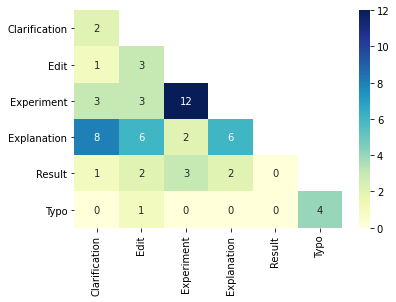

In [12]:
confusion_wrapper("req", label_map,"")

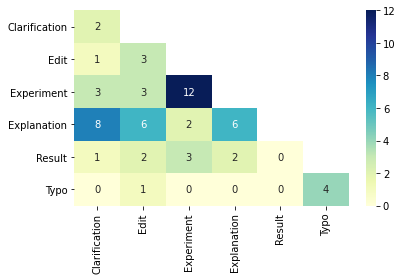

In [13]:
confusion_wrapper("req", label_map,"")
plt.tight_layout()
plt.savefig("rev_req_confusion.png")

In [14]:
#survey_wrapper("rating", "review_length", True, "", overall_stats_map)

In [15]:
import pandas as pd

In [16]:
def my_pivot(input_dict):
    output_dict = collections.defaultdict(list)
    for v_list in input_dict.values():
        for v in v_list:
            for key, val in v.items():
                output_dict[key].append(val)
            #output_dict["ratio"].append(v["rebuttal_length"]/v["review_length"])
    return output_dict



In [17]:

k = pd.DataFrame(my_pivot(overall_stats_map))
k.corr(method="spearman")

,review_length,rebuttal_length,rating
review_length,1.000000,0.468604,-0.065886
rebuttal_length,0.468604,1.000000,-0.163719
rating,-0.065886,-0.163719,1.000000


In [18]:
# sns.boxplot(data=k, x="rating", y="review_length", palette="Set3").set_title("Review length v/s rating")
# plt.ylabel("Review length (num. sentences)")
# plt.xlabel("Review rating")
# plt.savefig("new_length_rating.png")

In [19]:
# sns.scatterplot(data=k, x="review_length", y="rebuttal_length", hue="rating", palette="Set3").set_title("Review length v/s rebuttal length")
# plt.ylabel("Review length (num. sentences)")
# plt.xlabel("Rebuttal length (num. sentences)")
# plt.savefig("new_rev_reb_length.png")

In [20]:
ACCEPT, REJECT, OTHER = "Accept Reject Other".split()

accept_reject_map = {
    "":  OTHER,
"accept-praise": ACCEPT ,
"answer":ACCEPT  ,
"by-cr":  ACCEPT,
"by-cr_manu_No": ACCEPT ,
"by-cr_manu_Yes": ACCEPT ,
"concede-criticism":ACCEPT  ,
"contradict-assertion": REJECT ,
"done_manu_No": ACCEPT ,
"done_manu_Yes": ACCEPT ,
"followup": OTHER ,
"future": ACCEPT ,
"mitigate-criticism": REJECT ,
"mitigate-praise": REJECT ,
"multiple": OTHER ,
"other":  OTHER,
"refute-question": REJECT ,
"reject-criticism": REJECT ,
"reject-request_scope_No":  REJECT,
"reject-request_scope_Yes": REJECT ,
"social": OTHER ,
"structuring": OTHER ,
"summary": OTHER ,

}

EVALUATIVE, REQUEST, OTHER = "Evaluative Request Other".split()

eval_req_map = {
    "":  OTHER,
"accept-praise": EVALUATIVE ,
"answer": REQUEST ,
"by-cr": REQUEST ,
"by-cr_manu_No":  REQUEST,
"by-cr_manu_Yes":  REQUEST,
"concede-criticism":  EVALUATIVE,
"contradict-assertion":OTHER  ,
"done_manu_No": REQUEST ,
"done_manu_Yes": REQUEST ,
"followup": OTHER ,
"future":  REQUEST,
"mitigate-criticism": EVALUATIVE ,
"mitigate-praise": EVALUATIVE ,
"multiple": OTHER ,
"other":  OTHER,
"refute-question": REQUEST ,
"reject-criticism": REQUEST ,
"reject-request_scope_No": REQUEST ,
"reject-request_scope_Yes": REQUEST ,
"social": OTHER ,
"structuring": OTHER ,
"summary": OTHER ,

}


def rebuttal_label_maker():
    double_review_labels = {}
    sentence_annotations = orda_data["rebuttalsentenceannotation"]
    rebuttal_label_map = collections.defaultdict(list)
    for sent in sentence_annotations:
        review_id = sent["fields"]["review_id"]
        rebuttal_id = sent["fields"]["review_id"]
        comment_id, sentence_index = sent["fields"]["rebuttal_id"], sent["fields"]["rebuttal_sentence_index"]
        if review_id not in acceptable_pairs:
            continue
        elif rating_map[review_id] == 9:
            continue
        label = sent["fields"]["relation_label"]
            
        if not labels:
            continue
        else:
            aligned_list = json.loads(sent["fields"]["aligned_review_sentences"])
            if not aligned_list:
                continue
            rebuttal_label_map[(rebuttal_id, sent["fields"]["rebuttal_sentence_index"])].append({
                "relation": label,
                "aligned_sentences": aligned_list,
            "rating": rating_map[review_id],
            "initials": sent["fields"]["initials"],
            "num_sentences_mapped": sum(aligned_list),
            "frac_sentences_mapped": sum(aligned_list)/len(aligned_list),
            "er": eval_req_map[label],
            "ar": accept_reject_map[label],
        

            })
    return rebuttal_label_map

In [21]:
rebuttal_label_map = rebuttal_label_maker()

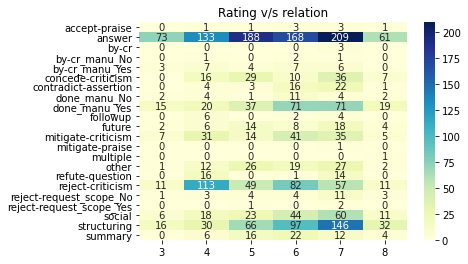

In [22]:
heatmap_wrapper("relation", "rating", rebuttal_label_map, title="Rating v/s relation")

In [23]:
vals = sorted(set(v["relation"]for b in rebuttal_label_map.values() for v in b ))

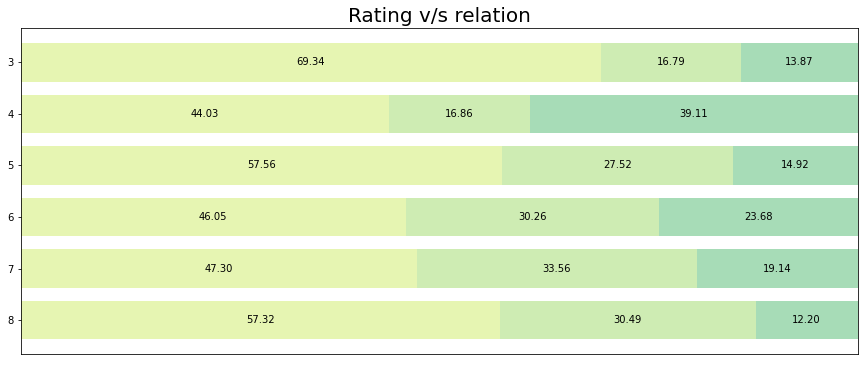

In [24]:
survey_wrapper(
    "rating", "ar", True, None,
    "Rating v/s relation",
    rebuttal_label_map)

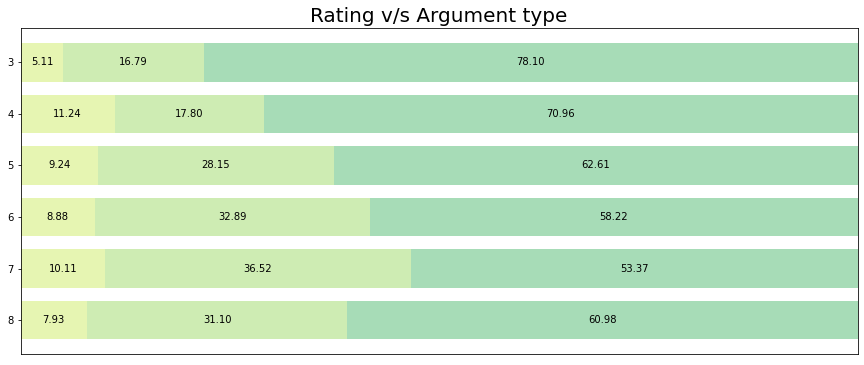

In [25]:
survey_wrapper(
    "rating", "er", True, None,
    "Rating v/s Argument type",
    rebuttal_label_map)

In [26]:
# ^ two possible hypotheses -- are htey interpreting things as request that aren't, or do they only respond to requests?

In [27]:
import collections
alignments = collections.defaultdict(list)
for (review_id, reb_idx), labels in rebuttal_label_map.items():
    for label in labels:
        initials = label["initials"]
        for rev_idx, is_aligned in enumerate(label["aligned_sentences"]):
            if is_aligned:
                alignments[(review_id, initials)].append({
                    "reb_idx": reb_idx,
                    "rev_idx": rev_idx,
                    "initials": initials,
                })
spearmen = []
for (rev_id, initials), data in alignments.items():
    b = pd.DataFrame(data)
    #print(b)
    maybe_value = b.corr('spearman')["rev_idx"]["reb_idx"]
    if str(maybe_value) == "nan":
        continue
    else:
        spearmen.append(b.corr('spearman')["rev_idx"]["reb_idx"])
    

/Users/nnayak/git_repos/iclr-discourse-dataset/iddve/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


72
29


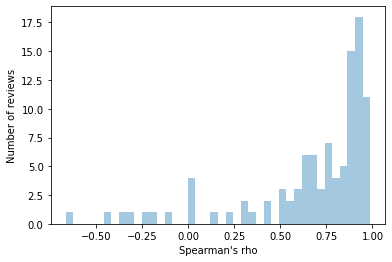

In [53]:
sns.distplot(spearmen, bins=40, kde=False)
plt.ylabel("Number of reviews")
plt.xlabel("Spearman's rho")
print(len([i for i in spearmen if i < 0.9]))
print(len([i for i in spearmen if i >= 0.9]))

In [29]:
print(rebuttal_label_map)
# num_sentences_mapped
# frac_sentences_mapped

mapping_info_map = collections.defaultdict(list)

for (review_id, reb_idx), labels in rebuttal_label_map.items():
    for label in labels:
        new_label

defaultdict(<class 'list'>, {('rJgLrhZq2X', 0): [{'relation': 'social', 'aligned_sentences': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rating': 7, 'initials': 'TJO', 'num_sentences_mapped': 0, 'frac_sentences_mapped': 0.0, 'er': 'Other', 'ar': 'Other'}, {'relation': 'social', 'aligned_sentences': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rating': 7, 'initials': 'MC', 'num_sentences_mapped': 0, 'frac_sentences_mapped': 0.0, 'er': 'Other', 'ar': 'Other'}], ('rJgLrhZq2X', 1): [{'relation': 'social', 'aligned_sentences': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rating': 7, 'initials': 'TJO', 'num_sentences_mapped': 0, 'frac_sentences_mapped': 0.0, 'er': 'Other', 'ar': 'Other'}, {'relation': 'social', 'aligned_sentences': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rating': 7, 'initials': 'MC', 'num_sentences_mapped': 0, 'frac_sentences_mapped': 0.0, 'er': 'Other', 'ar': 'Other'}, {'relation': 'accept-praise', 'aligned_sentences': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rating': 7, 'initia

NameError: name 'new_label' is not defined

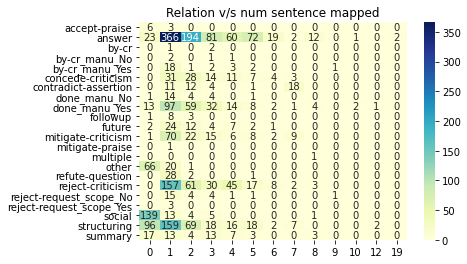

In [30]:
heatmap_wrapper("relation", "num_sentences_mapped", rebuttal_label_map, title="Relation v/s num sentence mapped")

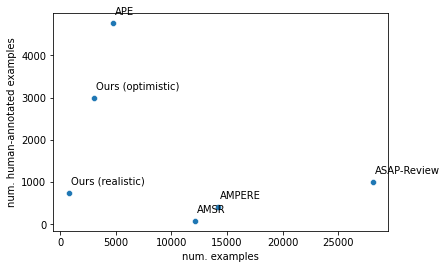

In [31]:
datasets = [
{
    "name": "AMPERE",
    "num. examples": 14200,
    "num. human-annotated examples": 400,
},
    {
    "name": "ASAP-Review",
    "num. examples": 28119,
    "num. human-annotated examples": 1000,
},
    {
    "name": "AMSR",
    "num. examples": 12135,
    "num. human-annotated examples": 77,
},
    {
    "name": "APE",
    "num. examples": 4764,
    "num. human-annotated examples":4764,
},
    {
    "name": "Ours (optimistic)",
    "num. examples": 3000,
    "num. human-annotated examples": 3000,
},
    {
    "name": "Ours (realistic)",
    "num. examples": 750,
    "num. human-annotated examples": 750,
},
]

dataset_df = pd.DataFrame(datasets)
sns.scatterplot(data=dataset_df, x="num. examples", y="num. human-annotated examples")
for i in range(dataset_df.shape[0]):
    plt.text(x=dataset_df["num. examples"][i]+200,
             y=dataset_df["num. human-annotated examples"][i]+200,
             s=dataset_df.name[i], 
          fontdict=dict(size=10),)
    

In [32]:
# plt.ylabel("Number of human-annotated reviews") 
# plt.ylabel("Total number of reviews in dataset")    
# plt.ylim(0,6000)
# plt.savefig("dataset_scatter.png")

In [33]:
# heatmap_wrapper("relation", "rating", rebuttal_label_map, title="Rating v/s relation")
# plt.savefig("rating-relation.png")

In [34]:
# survey_wrapper(
#      "rating", "ar", True, "Accept or reject",
#     "",
#     rebuttal_label_map)
# plt.savefig("ar_responses_rating")

In [35]:
# survey_wrapper(
#      "rating", "er", True, "Review argument type",
#     "",
#     rebuttal_label_map)
# plt.savefig("er_responses_rating.png")

In [36]:
print(len(double_review_labels))
num_double_labels = 0
for i, label in double_review_labels.items():
    print(i)
    print(label)
    if "1" in label and label["1"]:
        num_double_labels += 1
print(num_double_labels)

34
('HkeGURdb6X', 1)
{'arg': 'Evaluative', 'asp': 'Substance', 'pol': 'P-Positive'}
('SJgssoHT27', 1)
{'arg': 'Evaluative', 'asp': 'Substance', 'pol': 'P-Positive'}
('BkxIg3zKhX', 0)
{'arg': 'Evaluative', 'asp': 'Motivation/Impact', 'pol': 'P-Positive'}
('SylPHRPDnQ', 35)
{'arg': 'Request', 'req': 'Experiment', 'asp': 'Substance', 'pol': 'U-Neutral'}
('H1xX2I782m', 1)
{'arg': 'Evaluative', 'asp': 'Originality', 'pol': 'P-Positive'}
('H1xX2I782m', 10)
{'arg': 'Evaluative', 'asp': 'Originality', 'pol': 'P-Positive'}
('HyeZp_ivTQ', 5)
{'arg': 'Evaluative', 'asp': 'Substance', 'pol': 'N-Negative'}
('HyxHQfLq3m', 7)
{'arg': 'Evaluative', 'asp': 'Substance', 'pol': 'N-Negative'}
('Ske3D7Jqh7', 8)
{'arg': 'Evaluative', 'asp': 'Originality', 'pol': 'N-Negative'}
('r1eWc6qjnX', 0)
{'arg': 'Evaluative', 'asp': 'Substance', 'pol': 'P-Positive'}
('SyeS7CQ83m', 16)
{'arg': 'Evaluative', 'asp': 'Substance', 'pol': 'N-Negative'}
('H1lJ9-Pdn7', 1)
{'arg': 'Evaluative', 'asp': 'Motivation/Impact', 'pol

In [37]:
total_label_count = 0
for rev_id, labels in label_map.items():
    print(rev_id)
    total_label_count += len(labels)
    
total_label_count

('rJgLrhZq2X', 0)
('rJgLrhZq2X', 1)
('rJgLrhZq2X', 2)
('rJgLrhZq2X', 3)
('rJgLrhZq2X', 4)
('rJgLrhZq2X', 5)
('rJgLrhZq2X', 6)
('rJgLrhZq2X', 7)
('rJgLrhZq2X', 8)
('rJgLrhZq2X', 9)
('rJgLrhZq2X', 10)
('rJgLrhZq2X', 11)
('rJgLrhZq2X', 12)
('HJeXDu9h2X', 0)
('HJeXDu9h2X', 1)
('HJeXDu9h2X', 2)
('HJeXDu9h2X', 3)
('HJeXDu9h2X', 4)
('HJeXDu9h2X', 5)
('HJeXDu9h2X', 6)
('HJeXDu9h2X', 7)
('HJeXDu9h2X', 8)
('HJeXDu9h2X', 9)
('HJeXDu9h2X', 10)
('HJeXDu9h2X', 11)
('HJeXDu9h2X', 12)
('HJeXDu9h2X', 13)
('HJeXDu9h2X', 14)
('HJeXDu9h2X', 15)
('HJeXDu9h2X', 16)
('HJeXDu9h2X', 17)
('HJeXDu9h2X', 18)
('HJeXDu9h2X', 19)
('HJeXDu9h2X', 20)
('HJeXDu9h2X', 21)
('HJeXDu9h2X', 22)
('HJeXDu9h2X', 23)
('HJeXDu9h2X', 24)
('HJeXDu9h2X', 25)
('HJeXDu9h2X', 26)
('HJeXDu9h2X', 27)
('HJeXDu9h2X', 28)
('HJeXDu9h2X', 29)
('HJeXDu9h2X', 30)
('HJeXDu9h2X', 31)
('B1lChPhJpQ', 0)
('B1lChPhJpQ', 1)
('B1lChPhJpQ', 2)
('B1lChPhJpQ', 3)
('B1lChPhJpQ', 4)
('B1lChPhJpQ', 5)
('B1lChPhJpQ', 6)
('B1lChPhJpQ', 7)
('H1gVYFVS3X', 0)
('H

('Hyl_lXQF3X', 48)
('Hyl_lXQF3X', 49)
('SJgG0gkChX', 0)
('SJgG0gkChX', 1)
('SJgG0gkChX', 2)
('SJgG0gkChX', 3)
('SJgG0gkChX', 4)
('SJgG0gkChX', 6)
('SJgG0gkChX', 7)
('SJgG0gkChX', 8)
('H1gSPxyC3Q', 0)
('H1gSPxyC3Q', 1)
('H1gSPxyC3Q', 2)
('H1gSPxyC3Q', 3)
('H1gSPxyC3Q', 4)
('H1gSPxyC3Q', 5)
('H1gSPxyC3Q', 6)
('rJe1e3jj3X', 0)
('rJe1e3jj3X', 1)
('rJe1e3jj3X', 2)
('rJe1e3jj3X', 3)
('rJe1e3jj3X', 4)
('rJe1e3jj3X', 5)
('rJe1e3jj3X', 6)
('rJe1e3jj3X', 7)
('rJe1e3jj3X', 8)
('ryg4Fgr9hX', 0)
('ryg4Fgr9hX', 1)
('ryg4Fgr9hX', 2)
('ryg4Fgr9hX', 3)
('ryg4Fgr9hX', 4)
('ryg4Fgr9hX', 5)
('ryg4Fgr9hX', 6)
('ryg4Fgr9hX', 7)
('ryg4Fgr9hX', 8)
('ryg4Fgr9hX', 9)
('ryg4Fgr9hX', 10)
('ryg4Fgr9hX', 11)
('ryg4Fgr9hX', 12)
('ryg4Fgr9hX', 13)
('ryg4Fgr9hX', 14)
('ryg4Fgr9hX', 15)
('ryg4Fgr9hX', 16)
('ryg4Fgr9hX', 17)
('ryg4Fgr9hX', 18)
('ryg4Fgr9hX', 19)
('ryg4Fgr9hX', 20)
('ryg4Fgr9hX', 21)
('ryg4Fgr9hX', 22)
('ryg4Fgr9hX', 23)
('S1ldJZzch7', 0)
('S1ldJZzch7', 1)
('S1ldJZzch7', 2)
('S1ldJZzch7', 3)
('S1ldJZzch7

('Bygh4ga53m', 10)
('Bygh4ga53m', 11)
('Bygh4ga53m', 12)
('Bygh4ga53m', 13)
('Bygh4ga53m', 14)


3042

In [38]:
print(len(label_map))

2147


In [39]:
for k,v in rebuttal_label_map.items():
    print(k,v)
    break

('rJgLrhZq2X', 0) [{'relation': 'social', 'aligned_sentences': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rating': 7, 'initials': 'TJO', 'num_sentences_mapped': 0, 'frac_sentences_mapped': 0.0, 'er': 'Other', 'ar': 'Other'}, {'relation': 'social', 'aligned_sentences': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rating': 7, 'initials': 'MC', 'num_sentences_mapped': 0, 'frac_sentences_mapped': 0.0, 'er': 'Other', 'ar': 'Other'}]


In [40]:
data = []
for k,v in rebuttal_label_map.items():
    for i, j in enumerate(v):
        data.append({
            "review": k[0],
            "sent": k[1],
            "label_i":i,
            "frac_mapped": j["frac_sentences_mapped"],
            "num_mapped": j["num_sentences_mapped"],
        })

In [41]:
p = pd.DataFrame(data)

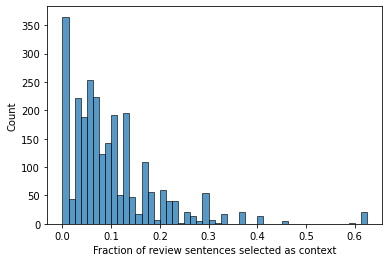

In [42]:
sns.histplot(data=p, x="frac_mapped")
plt.xlabel("Fraction of review sentences selected as context")
plt.savefig("frac_mapped.png")

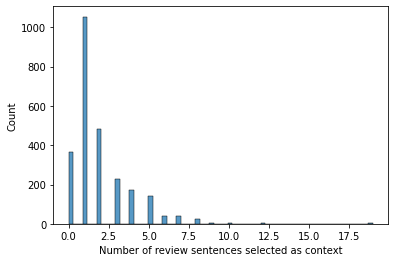

In [43]:

sns.histplot(data=p, x="num_mapped")
plt.xlabel("Number of review sentences selected as context")
plt.savefig("num_mapped.png")

In [44]:
data = []
review_map_counter = collections.defaultdict(dict)
for k,v in rebuttal_label_map.items():
    for label in v:
        for i, is_mapped in enumerate(label["aligned_sentences"]):
            if i in review_map_counter[k[0]]:
                if is_mapped:
                    review_map_counter[k[0]][i] += 1
            else:
                if is_mapped:
                    review_map_counter[k[0]][i] = 1
                else:
                    review_map_counter[k[0]][i] = 0


In [45]:
data = []
for review_id, sents in review_map_counter.items():
    data.append({
        "review": review_id,
        "num_mapped": len([i for i in sents if i > 0])/len(sents)
    })
p = pd.DataFrame(data)

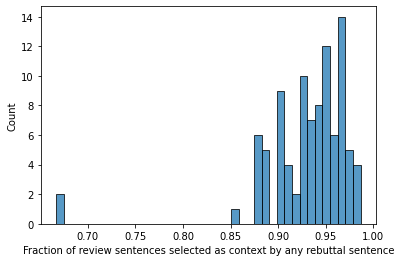

In [46]:
sns.histplot(data=p, x="num_mapped", bins=40)
plt.xlabel("Fraction of review sentences selected as context by any rebuttal sentence")
plt.savefig("frac_selected.png")

In [47]:
rev_keys = 'arg asp pol rating req struc'.split()
rows = []
for (review_id, sentence), labels in label_map.items():
    for label in labels:
        overall_dict = {
            "review_id": review_id,
            "sentence_idx":sentence,
            "sentence": sentences[(review_id, sentence)]
        }
        for key in rev_keys:
            if key in label:
                overall_dict[key] = label[key]
            else:
                overall_dict[key] = ""
        rows.append(overall_dict)
        
import csv
with open('review_sentences.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

In [48]:
rev_keys = ["relation", "rating"]
rows = []
for (review_id, sentence), labels in rebuttal_label_map.items():
    for label in labels:
        overall_dict = {
            "review_id": review_id,
            "sentence_idx":sentence,
            "sentence": rebuttal_sentences[(review_id, sentence)]
        }
        for key in rev_keys:
            if key in label:
                overall_dict[key] = label[key]
            else:
                overall_dict[key] = ""
        rows.append(overall_dict)
        
import csv
with open('rebuttal_sentences.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

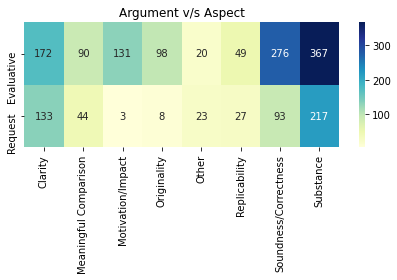

In [49]:
heatmap_wrapper("arg", "asp", label_map, title="Argument v/s Aspect")
plt.tight_layout()
plt.savefig("arg_asp.png")

In [50]:
import pandas as pd

rev_ctr = collections.Counter()
reb_ctr = collections.Counter()
kappas = {"MS": 0.3105510806,
"LA": 0.4371162606,
"SM": 0.4573210768,
"AN": 0.5372586971,
"RG": 0.5586631903,
"MAD": 0.5627859685,
"KG": 0.5926698993,
"AV": 0.6125775947,
"SW": 0.6977059959,
}

for label_list in label_map.values():
    for label in label_list:
        initials = label["initials"]
        if initials in kappas:
            rev_ctr[initials] += 1

for label_list in rebuttal_label_map.values():
    for label in label_list:
        initials = label["initials"]
        if initials in kappas:
            reb_ctr[initials] += 1
        
df_info = []
for initials, kappa in kappas.items():
    df_info.append(
    {"initials": initials,
     "kappa":kappa,
    "rev_sentences": rev_ctr[initials],
    "reb_sentences": reb_ctr[initials],
    "total": rev_ctr[initials] + reb_ctr[initials]})
    
ann_info = pd.DataFrame.from_dict(df_info)
ann_info

,initials,kappa,rev_sentences,reb_sentences,total
0,MS,0.310551,39,0,39
1,LA,0.437116,219,229,448
2,SM,0.457321,118,48,166
3,AN,0.537259,286,6,292
4,RG,0.558663,554,637,1191
5,MAD,0.562786,432,386,818
6,KG,0.592670,343,371,714
7,AV,0.612578,262,274,536
8,SW,0.697706,382,419,801


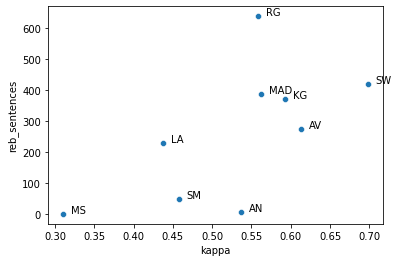

In [51]:
sns.scatterplot(data=ann_info, x="kappa", y="reb_sentences")

for i in range(ann_info.shape[0]):
    plt.text(x=ann_info.kappa[i]+0.01,
             y=ann_info.reb_sentences[i]+2,
             s=ann_info.initials[i], 
          fontdict=dict(size=10),)
    

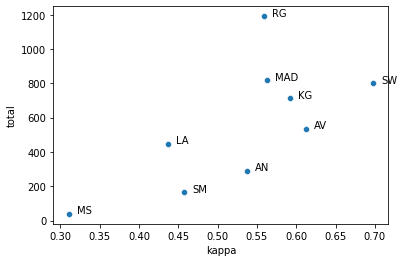

In [52]:
sns.scatterplot(data=ann_info, x="kappa", y="total")

for i in range(ann_info.shape[0]):
    plt.text(x=ann_info.kappa[i]+0.01,
             y=ann_info.total[i]+2,
             s=ann_info.initials[i], 
          fontdict=dict(size=10),)
    